# PILLS UTXO analysis

There are two ways to figure PILLS balances at a specific historical point:

1. Treat the time series of PILLS transfers as a graph of unspent transaction outputs (UTXOs), using the same model as Bitcoin or Cardano.
2. Use the EVM, rewind to the block corresponding to the point in time, and query the PILLS ERC20 contract for the balance of each address we know about.

Since I already obtained the time series of transfers as a CSV file, we'll start with the first option.

In [67]:
import copy
import json
import pandas as pd
import pendulum as pdl
from collections import defaultdict

## Import PILLS transfers

ERC-20 transfers were obtained by querying luabase, who have extracted all these transfers for us.

Etherscan uses a state-trace/inspect method to extract ERC-20 transfers that occur within transactions (so-called "internal transactions"). I presume luabase does the same.

In [2]:
df_transfers = pd.read_csv('data/pills-transfers.csv')
df_transfers.head()

,block_number,block_hash,block_timestamp,transaction_hash,log_index,token_address,from,to,value
0,21627928,0x0000c9d900000c8fd51e65690ccfa9bd192d57a86baa...,2021-11-10T10:17:06,0x527e28520ee4fb3a8992b6e33d0a3f376718bcbef750...,2,0xb66b5d38e183de42f21e92abcaf3c712dd5d6286,0x0000000000000000000000000000000000000000,0xd12fab721684540f7d2e3dfd22205baf83ff3d82,1.000000e+18
1,21628059,0x0000c9d90000125f2872af40870b4c1543d13913e93f...,2021-11-10T10:18:52,0x1969ad88e20c9b4e158c2faea6d731d0e726a7046396...,2,0xb66b5d38e183de42f21e92abcaf3c712dd5d6286,0x0000000000000000000000000000000000000000,0xd12fab721684540f7d2e3dfd22205baf83ff3d82,1.469738e+23
2,21628568,0x0000c9da00000c0b0ff403dace525d5139d5911aa3e9...,2021-11-10T10:25:57,0xf39a8945f9960e6d7db90061b9e178aa3598c37cc2d9...,2,0xb66b5d38e183de42f21e92abcaf3c712dd5d6286,0x0000000000000000000000000000000000000000,0xa3602aa3924300d9b69a2b7d2c8702adaef6ef91,8.785494e+18
3,21628632,0x0000c9da00000eb9243404119d455112fc6d2b360c74...,2021-11-10T10:26:48,0x343e416e0fd073c2a242a361af0f544966c81b8fe07c...,0,0xb66b5d38e183de42f21e92abcaf3c712dd5d6286,0xd12fab721684540f7d2e3dfd22205baf83ff3d82,0x02fbd037a4db4a49f8afb0ff092bd3ad27844307,7.700000e+22
4,21628884,0x0000c9db0000018783f8af96fe4407f186da84307500...,2021-11-10T10:30:28,0x15f9214982dce86318230fa4721c1314aa8a6e00c75c...,6,0xb66b5d38e183de42f21e92abcaf3c712dd5d6286,0x02fbd037a4db4a49f8afb0ff092bd3ad27844307,0x93d93f3d1aa417b212bae56d8df9c88dccf73a31,6.070200e+22


## Load NEO Pools

I already have the neopools addresses because I've previously analyzed them.

In [90]:
with open('data/neo-pools.json', 'r') as f:
    neopools = json.load(f)

neopool_addrs = [ x['address'] for x in neopools ]
print(neopool_addrs)

['0x7A93C6dDEbc2089F6D5bcccF1025d6D0E31d4DA4', '0x47775F72E8bfa98dE4613db6cD4b5772aC4aBEC8', '0x5406566EDCD5B108212Bb69382a8869D761E738E', '0xdf3A3D03a92F54f8859355924f4581443B80C714', '0x7373E5b59bf20345b0D452f9a294A51429ca1F9b', '0x9bd3dACe24745Eb117c1F7f93AAEC5e37333c079', '0x7928de9d6DB88280DBa4613864a518A98F32D342', '0xaDb29fBBb9962Fe643676e2433114F0446923221', '0x60131EC5BE073F1c34A9b506ce30eA7aAC7eed15', '0x62CfcABA772e90F743990A8bcEDAC04AbBF7E75f', '0x7E01c21789DEF6572E31Ab6c67A4182E0808428B', '0x2D5F05D8e578397889f5F5C88d8e3b81D8a6f865', '0x578fb737cf5F3814Ddd80Cd6a7b4FFF9504c0c39', '0xb6bA5d27b00c2E62e32c0716D7c6505463cFBbf2', '0xb31bF9a835584d18595d886D35157467576A76e8', '0xde1592f643F9c77f186970daa43D3cAB22C0fd22', '0xeF5627d8B7BC8102E0C9760F62E0c5b0b7F38AF6', '0x80da05De8B759B7A9399F43C04A859cC0eaA24AC', '0x983A4dA9E8baC8b8F2F04B161968906B780f3629', '0x63AD93bAb2842Fefec06630b9ddC7A2351D7cb91', '0x616a0030688329b4FaaFda8Cf469f1899e58cBfC', '0x94005434C078e9d8cC23fF4b5D88FC

## Build UTXO State

Scan through the transfers in block-order.

Update the to- and from- addresses by the value of the transfer.

The state at the end of this process represents the "unspent transaction outputs" - which are better known as address balances.

In [135]:
utxo = {}
count = 0
stop_timestamp = pdl.parse('2022-04-15')

for tx in df_transfers.to_dict(orient="records"):
    # adjust balances by 18 decimal places per ERC-20
    value = tx['value'] / 10**18

    # ensure to and from addresses are in utxo dict
    if tx['from'] not in utxo:
        utxo[tx['from']] = 0
    if tx['to'] not in utxo:
        utxo[tx['to']] = 0

    # reduce balance of from by value
    utxo[tx['from']] -= value

    # increase balance of to by value
    utxo[tx['to']] += value

    # print(tx)

    if pdl.parse(tx['block_timestamp']) > stop_timestamp:
        print(f"stopping at transaction: {tx}")
        break
    
    count += 1
    if count % 10000 == 0:
        print(tx['block_timestamp'])

# keep the full UTXO state, including addresses with dust
utxo_dusty = copy.copy(utxo)

2021-11-14T10:08:13
2021-11-20T12:10:54
2021-11-29T12:39:09
2021-12-13T08:45:15
2022-01-02T14:00:47
2022-01-15T15:35:41
2022-01-18T07:16:54
2022-01-21T15:37:16
2022-01-25T20:05:08
2022-01-31T19:13:07
2022-02-07T22:24:57
2022-02-13T22:02:44
2022-02-17T19:39:24
2022-02-23T19:08:43
2022-03-02T22:55:45
2022-03-17T15:32:20
2022-04-08T12:57:36
stopping at transaction: {'block_number': 36076462, 'block_hash': '0x0001923e00000187fce22ad6196b3e69c6bbdc46067189c087328e6ab881852e', 'block_timestamp': '2022-04-15T00:06:45', 'transaction_hash': '0x0acf3d58fa3061cb5e0abbd82623bd79539f3f5658542becd2b372d55a9524c1', 'log_index': 15, 'token_address': '0xb66b5d38e183de42f21e92abcaf3c712dd5d6286', 'from': '0x1d028122deefcfb859426f3b957ddf82459a7c2a', 'to': '0x3823a62339c5e9a75990efd1f91cdeff73bda609', 'value': 6.443645661134797e+18}


## Filter dust

Remove addresses with PILLS balances below 0.0001.

In [139]:
print(f"There are {len(utxo_dusty)} dusty addresses with PILLS balances.")

df_balances = pd.DataFrame(data={'address': utxo_dusty.keys(), 'balance': utxo_dusty.values()})

# remove addresses with dust
df_balances = df_balances.loc[df_balances['balance'] > 0.0001]
print(f"There are {len(df_balances)} clean addresses with PILLS balances.")

df_balances = df_balances.sort_values(by='balance', ascending=False)
df_balances.to_csv('data/pills-balances-snapshot.csv', index=False)
df_balances.head()

There are 9487 dusty addresses with PILLS balances.
There are 2081 clean addresses with PILLS balances.


,address,balance
9456,0x326a7d91b6f767458599e7d93dfc850d2e083d30,2.823177e+06
2160,0x9c775d3d66167685b2a3f4567b548567d2875350,2.334648e+06
1,0xd12fab721684540f7d2e3dfd22205baf83ff3d82,1.858032e+05
9371,0xa431fdd6d23f0d7c4b4b92f4ad866a5939b53abb,1.663983e+05
7716,0x3beef19946b0595621650793d45c1cb06e9f810a,1.401622e+05


## PILLS balances

Let's examine the distribution of PILLS across these addresses.

                                                 balance
address                                                 
0x326a7d91b6f767458599e7d93dfc850d2e083d30  2.823177e+06
0x9c775d3d66167685b2a3f4567b548567d2875350  2.334648e+06
others                                      1.166146e+06
0xd12fab721684540f7d2e3dfd22205baf83ff3d82  1.858032e+05
0xa431fdd6d23f0d7c4b4b92f4ad866a5939b53abb  1.663983e+05


<AxesSubplot: title={'center': 'Balances at block 36076462'}, ylabel='balance'>

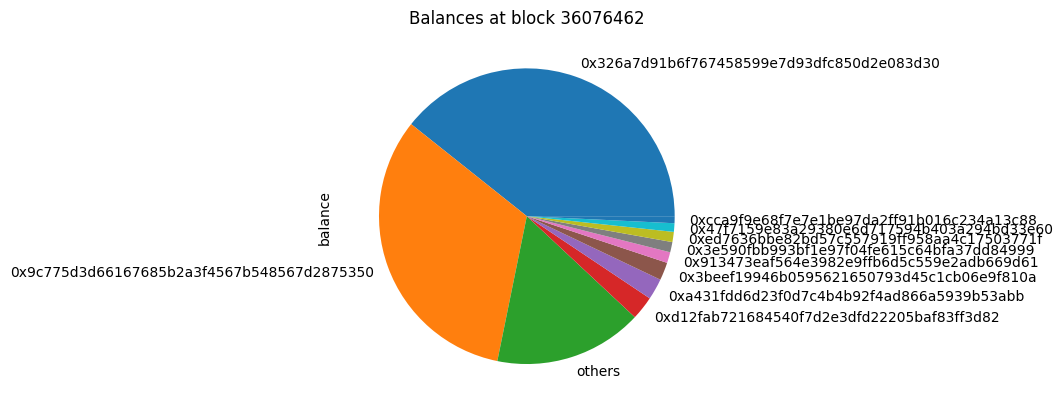

In [140]:
df_draw = df_balances.copy()
df_draw.loc[df_draw['balance'] < 50000, 'address'] = 'others'
df_draw = df_draw.groupby('address')['balance'].sum().reset_index()
df_draw = df_draw.sort_values(by='balance', ascending=False)
df_draw = df_draw.set_index('address')
print(df_draw.head())
df_draw.plot.pie(y='balance', title="Balances at block 36076462", legend=False)

## Volume of PILLS transferred over time

   block_number          value
0      21627928       1.000000
1      21628059  146973.779976
2      21628568       8.785494
3      21628632   77000.000000
4      21628884   60702.000000


<AxesSubplot: title={'center': 'volume per block range'}, xlabel='blocks'>

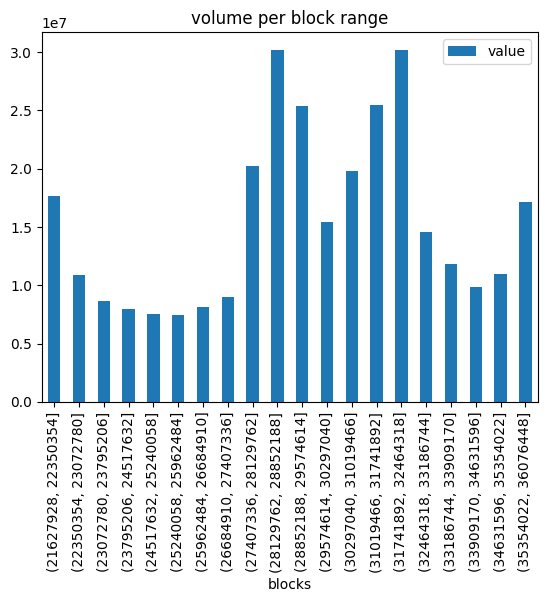

In [141]:
df_timeseries = df_transfers[['block_number', 'value']].copy()
# adjust values by 18 decimal places
df_timeseries['value'] = df_timeseries['value'].apply(lambda x: x / 10**18)
print(df_timeseries.head())

min_block_number = min(df_timeseries['block_number'])
# max_block_number = max(df_timeseries['block_number'])
max_block_number = 36076462 # corresponds to April 15, 2022
block_range = max_block_number - min_block_number

# aggregate volume into block ranges
bins = list(range(min_block_number, max_block_number, int(block_range / 20)))
df_timeseries['blocks'] = pd.cut(df_timeseries['block_number'], bins)
df_timeseries[['blocks', 'value']].groupby('blocks').sum().plot.bar(title="volume per block range")

## Recover address state from transfers

Replay all PILLS ERC-20 transfers, building a balances map for each address as if they were all contracts.

For addresses that actually ARE contracts (e.g. liquidity pools, neo pools, etc) their map will contain the balance for each depositor address.

In [142]:
state = defaultdict(lambda: defaultdict(int))
balance_pills = defaultdict(int)

for tx in df_transfers.to_dict(orient="records"):
    # adjust by 18 decimal places
    value = tx['value'] / 10**18

    # when transfer is deposit(), state[to_addr] represents the contract at to_addr
    # when transfer is withdraw(), state[to_addr] represents depositor address

    # the contract contains a map for balances with from_addr as the key
    state[tx['to']][tx['from']] += value
    state[tx['to']]['balance'] += value

    # the from_address balance is decreased by the value
    # when from_address is a contract, this reduces the balance for that address
    state[tx['from']][tx['to']] -= value
    state[tx['from']]['balance'] -= value

    balance_pills[tx['to']] += value
    balance_pills[tx['from']] -= value

first_addr = list(state.keys())[0]
state[first_addr]['balance'] == balance_pills[first_addr]
state[first_addr]

defaultdict(int,
            {'0x0000000000000000000000000000000000000000': 907777.8792954009,
             'balance': 214389.89324567,
             '0x02fbd037a4db4a49f8afb0ff092bd3ad27844307': -301955.6966596803,
             '0xd43877b2b86faec2f6e7184a6988143905361cb1': 45311.86617275486,
             '0x99ba675bc20700e0bc4ff4bae642321b8e7a8d3d': -16334.999999999998,
             '0x5dd596c901987a2b28c38a9c1dfbf86fffc15d77': 9012.000000000002,
             '0xc7dad2e953dc7b11474151134737a007049f576e': 0.0,
             '0xbb8799657915e203d880f6a581a41a5e4f828620': -11755.135901577469,
             '0x92fcfc79187bc2db094c784d2a1b09e427ede24f': 17018.30370583672,
             '0x0f763341b448bb0f02370f4037fe4a2c84c9283f': -24999.999999999996,
             '0xcbb69539451147c3cf4eaee7bda87948915a3916': -49999.99999999999,
             '0xde583e18cfd40668fe102d366e87aa377ad5c3aa': -73.0,
             '0x1b60f1fe8012ed4583f0e7aab5b134ffd7494855': -74.0,
             '0x46724faa6ccaaa641696

## Deposits to Neo Pools

Examine the state map we just built.

Aggregate balances for each address across all of the Neo Pools.

In [145]:
neopool_total = 0
neopool_balance = defaultdict(int)

# examine the state for each neo pool address
for addr in neopool_addrs:

    # a special key called 'balance' contains the balance for the entire contract
    neopool_total += state[addr]['balance']

    # obtain deposited balance for all addresses that interacted with Neo Pool
    for deposit_addr in state[addr].keys():
        if deposit_addr == 'balance':
            continue

        # increase balance of deposit address
        neopool_balance[deposit_addr] += state[addr][deposit_addr]

print(f"{neopool_total} PILLS identified in Neo Pools")

# remove dust, sort, and save for later
df_neopools = pd.DataFrame({'address': neopool_balance.keys(), 'balance': neopool_balance.values()})
df_neopools = df_neopools.loc[df_neopools['balance'] > 0.001]
df_neopools = df_neopools.sort_values('balance', ascending=False)
df_neopools.to_csv('data/neopool_balance.csv', index=False)

# check how much dust we removed
print(f"{df_neopools['balance'].sum()} PILLS remain after removing dust")
print(f"{neopool_dusty - df_neopools['balance'].sum()} PILLS lost to dust.")

4080287.3140030573 PILLS identified in Neo Pools
4080287.3134294758 PILLS remain after removing dust
0.0005735834129154682 PILLS lost to dust.


## Addresses with PILLS in Neo Pools

                                                  balance
address                                                  
others                                      862725.618141
0x19145b49fd5e4c345822a4a83fe5543c5bbb785c  837704.455483
0x2728e32174fc95de00695007c9134fa03dc8b434  423613.264555
0xe5fae1a033ad8cb1355e8f19811380afd15b8bba  372390.201345
0x454e1e7be939faeac40afac6fb9309a6d4a4cc99  258108.934643


<AxesSubplot: title={'center': 'Balances in Neo Pools'}, ylabel='balance'>

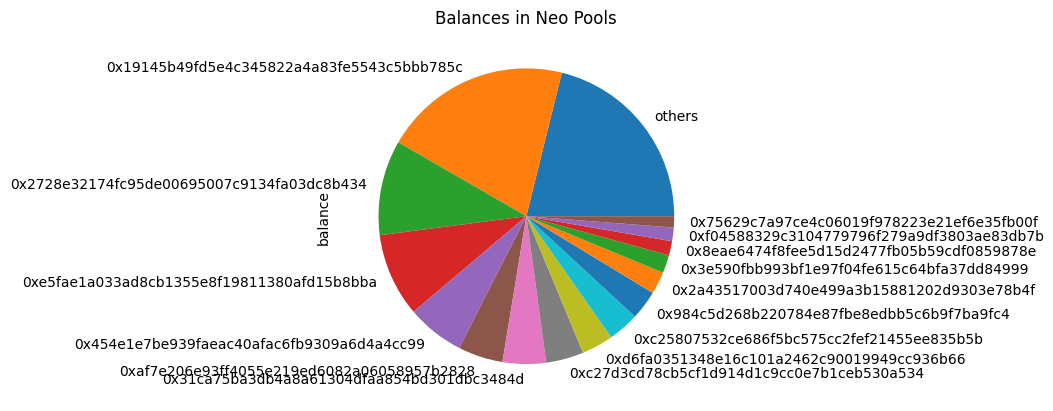

In [122]:
df_draw = df_neopools.copy()
df_draw.loc[df_draw['balance'] < 50000, 'address'] = 'others'
df_draw = df_draw.groupby('address')['balance'].sum().reset_index()
df_draw = df_draw.sort_values(by='balance', ascending=False)
df_draw = df_draw.set_index('address')
print(df_draw.head())
df_draw.plot.pie(y='balance', title="Balances in Neo Pools", legend=False)

## PILLS in Liquidity Pools

In [152]:
spirit_router = "0x16327e3fbdaca3bcf7e38f5af2599d2ddc33ae52"
pills_wftm_lp_spirit = "0x9c775d3d66167685b2a3f4567b548567d2875350"
pills_mim_lp_morpheus = "0x93d93f3d1aa417b212bae56d8df9c88dccf73a31"
morpheus_swap_deployer = "0x02fbd037a4db4a49f8afb0ff092bd3ad27844307"

# state[spirit_router]